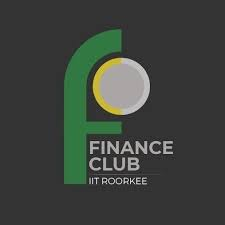


# Credit Card Behavior Score Prediction  
### *A FinClub IITR Open Project*  
#### *Leveraging Classification & Risk-Based Techniques for Financial Insights*  

---

## 📌 Project Overview  
**Objective:** Develop a predictive model to assess credit card user behavior scores using machine learning classification techniques and risk-based analysis.  

**Significance:**  
- Enables proactive risk management for financial institutions  
- Personalizes credit offerings based on customer behavior patterns  
- Reduces default rates through early identification of risk factors  

In [ ]:
!pip install optuna > /dev/null 2>&1
!pip install catboost > /dev/null 2>&1
!pip install xgboost > /dev/null 2>&1
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    fbeta_score,
    make_scorer
)
from sklearn.calibration import calibration_curve
import optuna
from optuna.samplers import TPESampler

In [3]:
df=pd.read_csv(r"/content/train_dataset_final1.csv")
print(df.shape)
df

(25247, 27)


Customer_ID  marriage  sex  education  LIMIT_BAL   age  pay_0  pay_2  \
0             5017         2    0          2      60000  25.0      2      2   
1             5018         2    1          1     290000  24.0      0      0   
2             5019         1    0          2     180000  63.0      0      0   
3             5020         1    1          2     210000  43.0      0      0   
4             5021         2    0          1     280000  32.0     -2     -2   
...            ...       ...  ...        ...        ...   ...    ...    ...   
25242        30259         1    1          2      90000  33.0      0      0   
25243        30260         1    0          2      60000  49.0      0      0   
25244        30261         2    0          1     120000  31.0     -1     -1   
25245        30262         1    1          4     390000  40.0      0      0   
25246        30263         1    1          2     160000  58.0     -1     -1   

       pay_3  pay_4  ...  Bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  \
0          2      0  ...   20750.63   2000.21      0.00   1134.85   1821.78   
1         -2     -2  ...    1350.30      0.00      0.17      0.00   2700.10   
2          0      0  ...   52991.51   2086.94   2199.99   1845.66   2000.35   
3          0      0  ...   76945.47   3348.07   3380.91   3400.45   2683.97   
4         -2     -2  ...       1.35    999.78   3186.27  45027.78   2100.09   
...      ...    ...  ...        ...       ...       ...       ...       ...   
25242      0      0  ...   90042.87   2800.18   3999.97   8000.09   5347.85   
25243      0      0  ...   19204.07  22000.17   2187.56   2501.13   2512.09   
25244     -1     -1  ...    9834.64   1315.83   1315.60    533.08   4116.08   
25245      0      0  ...  199013.32   7636.03   5652.86   5544.67   5532.37   
25246     -1     -1  ...    1443.08   1442.81   1443.06   1442.97   1443.31   

       pay_amt5  pay_amt6  AVG_Bill_amt  PAY_TO_BILL_ratio  next_month_default  
0       1500.03   1500.24      41511.50               0.03                   0  
1          0.00   1349.72       2534.50               0.27                   0  
2       1923.00   1999.78      50422.00               0.04                   0  
3       2744.00   2892.10      86229.50               0.04                   0  
4          0.01      0.27      11814.33               0.72                   0  
...         ...       ...           ...                ...                 ...  
25242   3699.98   3128.06      82312.50               0.05                   0  
25243   4004.89   2604.22      41371.67               0.14                   1  
25244   9834.10   7100.12       3071.83               1.31                   1  
25245   5859.09   6818.14     197278.83               0.03                   0  
25246   1442.72   1443.00       1443.00               1.00                   0  

[25247 rows x 27 columns]

In [4]:
df_test=pd.read_csv(r'/content/validate_dataset_final.csv')
print(df_test.shape)
df_test

(5016, 26)


Customer_ID  marriage  sex  education  LIMIT_BAL  age  pay_0  pay_2  \
0               1         1    1          2     220000   32      0      0   
1               2         2    0          1     350000   35     -1     -1   
2               3         2    1          1     310000   39      0      0   
3               4         1    0          2      20000   47      0      0   
4               5         2    1          2     500000   30      0      0   
...           ...       ...  ...        ...        ...  ...    ...    ...   
5011         5012         1    0          2     240000   51      0      0   
5012         5013         1    1          3      60000   33      0      0   
5013         5014         1    0          1     290000   36      1     -2   
5014         5015         1    1          2     120000   28      0      0   
5015         5016         2    1          1     100000   24      0      0   

      pay_3  pay_4  ...  Bill_amt5  Bill_amt6  pay_amt1  pay_amt2  pay_amt3  \
0         0      0  ...   17831.13   15670.47   2000.03   3999.90   1419.80   
1        -1      0  ...   10832.78    2261.45  33891.01  16267.19   4026.80   
2         0      0  ...  240520.57  246524.45  11026.94  10499.83  14000.32   
3         0      2  ...   15040.17   14749.97   1200.00   2799.83      0.14   
4         0      0  ...   69054.15   64841.30  25463.94  43095.31   7521.96   
...     ...    ...  ...        ...        ...       ...       ...       ...   
5011      0      0  ...  106832.47  109060.11   3591.87   3718.80   3797.93   
5012      0      0  ...   29062.53   28862.41   2100.23   3000.32   1499.86   
5013     -1     -1  ...   16725.60   17427.88      0.00    568.10  16165.93   
5014      0      0  ...   75710.06   77502.18   3283.48   2999.75   5000.26   
5015      0      0  ...   14718.27   29426.58   1552.85   4999.62     87.25   

      pay_amt4  pay_amt5  pay_amt6  AVG_Bill_amt  PAY_TO_BILL_ratio  
0      1999.97   3000.21  30788.71      23456.33               0.31  
1       234.10   1565.11  26346.39      13660.33               1.00  
2     10000.12  10000.16  10000.21     258034.17               0.04  
3      1499.93      0.02   1000.26      13333.33               0.08  
4      9065.17   8841.07  12000.21      77204.50               0.23  
...        ...       ...       ...           ...                ...  
5011   3820.66   3949.01   3976.22     103737.83               0.04  
5012   1499.82   1099.82   1100.18      41858.83               0.04  
5013   1000.03   1000.05   1000.15       8481.17               0.39  
5014   3000.13   2999.95   4000.04      84492.00               0.04  
5015  14760.83  29513.97    330.11      27439.33               0.31  

[5016 rows x 26 columns]

In [5]:
df.columns

Index(['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1',
       'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6',
       'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default'],
      dtype='object')

In [6]:
#dropped the unnecessary columns
df.drop(['Customer_ID'],axis=1,inplace=True)
df_test.drop(['Customer_ID'],axis=1,inplace=True)

In [7]:
#checking for nan values
df.isna().sum()

marriage                0
sex                     0
education               0
LIMIT_BAL               0
age                   126
pay_0                   0
pay_2                   0
pay_3                   0
pay_4                   0
pay_5                   0
pay_6                   0
Bill_amt1               0
Bill_amt2               0
Bill_amt3               0
Bill_amt4               0
Bill_amt5               0
Bill_amt6               0
pay_amt1                0
pay_amt2                0
pay_amt3                0
pay_amt4                0
pay_amt5                0
pay_amt6                0
AVG_Bill_amt            0
PAY_TO_BILL_ratio       0
next_month_default      0
dtype: int64

In [8]:
#using median of the age column to fill up the nan spaces
df['age'].fillna(df['age'].median(),inplace=True)

<ipython-input-8-3404922453>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(),inplace=True)


In [9]:
#checking for data imbalance
df['next_month_default'].value_counts()

next_month_default
0    20440
1     4807
Name: count, dtype: int64

In [10]:
df['marriage'].value_counts()
# {
#     0:not disclosed,
#     1:single,
#     2:married,
#     3:divorced
# }

marriage
2    13441
1    11480
3      273
0       53
Name: count, dtype: int64

In [11]:
#since the divorced and undisclosed ones only constitute 1.3% of the dataset they can be combined
df['marriage'] = df['marriage'].replace(3, 0)
df_test['marriage'] = df_test['marriage'].replace(3, 0)

In [12]:
df['marriage'].value_counts()

marriage
2    13441
1    11480
0      326
Name: count, dtype: int64

In [13]:
df['education'].value_counts()
# "education": {
#         0: "Unknown/Not Disclosed",
#         1: "Graduate School (Masters/PhD)",
#         2: "University (Bachelor's)",
#         3: "High School",
#         4: "Others (Vocational/Trade)",
#         5: "Less than High School",
#         6: "Dropout"
#     }

education
2    11717
1     8988
3     4115
5      253
4      116
6       44
0       14
Name: count, dtype: int64

In [14]:
#since not disclosed,less than high school and dropouts 1.23% of the dataset they could be combined
df['education'] = df['education'].replace([0, 5, 6], 4)
df_test['education'] = df_test['education'].replace([0, 5, 6], 4)
df['education'].value_counts()

education
2    11717
1     8988
3     4115
4      427
Name: count, dtype: int64

# Initial Feature Engineering
Created 4 features to summarize payment/billing behavior:

- **`AVG_PAY_amt`**  
  Mean of `pay_amt1` to `pay_amt6`

- **`bill_limit_ratio`**  
  `AVG_Bill_amt / (LIMIT_BAL + 1)` → Credit utilization

- **`missed_payments`**  
  Count of months with `pay_amt > 0`

- **`bill_trend`**  
  Linear slope of bill amounts → Spending trend

In [15]:
df['AVG_PAY_amt']=(df['pay_amt1']+df['pay_amt2']+df['pay_amt3']+df['pay_amt4']+df['pay_amt5']+df['pay_amt6'])/6

df['bill_limit_ratio'] = df['AVG_Bill_amt'] / (df['LIMIT_BAL'] + 1)

pay_cols = [col for col in df.columns if col.startswith("pay_")]
df['missed_payments'] = (df[pay_cols] > 0).sum(axis=1)

bill_cols = [col for col in df.columns if 'Bill_amt' in col]
df['bill_trend'] = df[bill_cols].apply(lambda row: np.polyfit(range(len(row)), row, 1)[0], axis=1)


df_test['AVG_PAY_amt']=(df_test['pay_amt1']+df_test['pay_amt2']+df_test['pay_amt3']+df_test['pay_amt4']+df_test['pay_amt5']+df_test['pay_amt6'])/6

df_test['bill_limit_ratio'] = df_test['AVG_Bill_amt'] / (df_test['LIMIT_BAL'] + 1)

pay_cols = [col for col in df_test.columns if col.startswith("pay_")]
df_test['missed_payments'] = (df_test[pay_cols] > 0).sum(axis=1)

bill_cols = [col for col in df.columns if 'Bill_amt' in col]
df_test['bill_trend'] = df_test[bill_cols].apply(lambda row: np.polyfit(range(len(row)), row, 1)[0], axis=1)

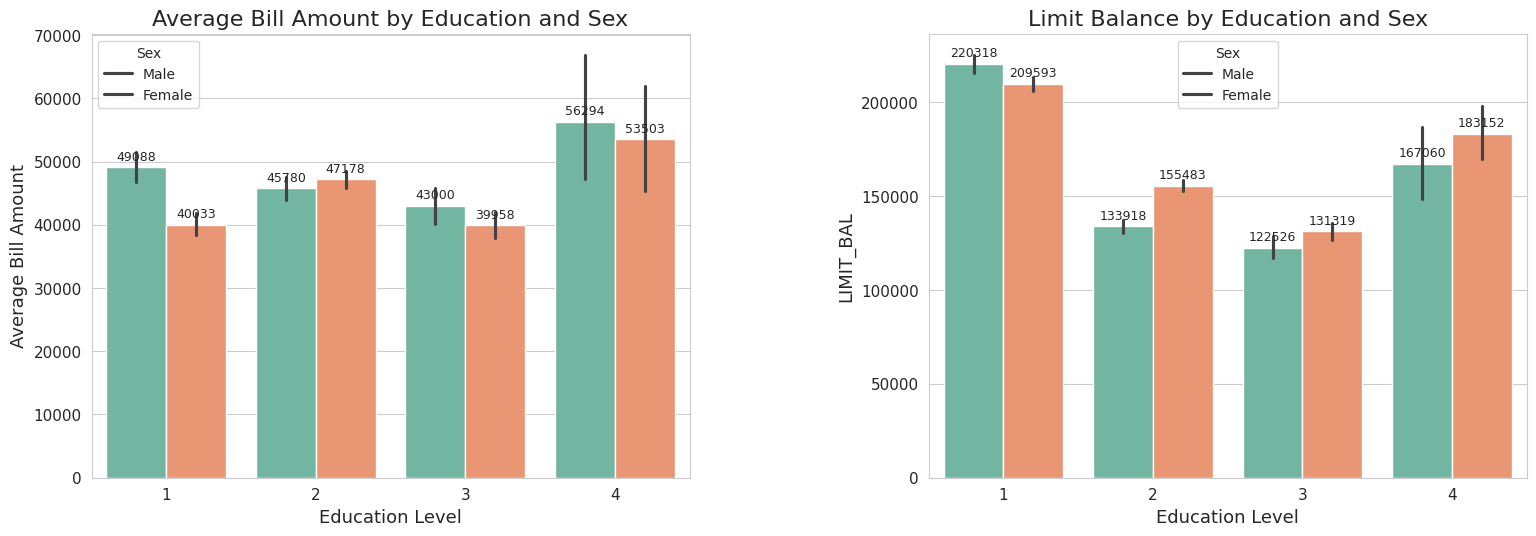

In [16]:
plt.clf()
plt.close()
sns.set_style("whitegrid")
plt.rcParams.update({'axes.titlesize': 16, 'axes.labelsize': 13,
                     'xtick.labelsize': 11, 'ytick.labelsize': 11})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x='education', y='AVG_Bill_amt', hue='sex', data=df,
            ax=axes[0], palette='Set2')
axes[0].set_title("Average Bill Amount by Education and Sex")
axes[0].set_xlabel("Education Level")
axes[0].set_ylabel("Average Bill Amount")
axes[0].legend(title='Sex', labels=['Male', 'Female'])

sns.barplot(x='education', y='LIMIT_BAL', hue='sex', data=df,
            ax=axes[1], palette='Set2')
axes[1].set_title("Limit Balance by Education and Sex")
axes[1].set_xlabel("Education Level")
axes[1].legend(title='Sex', labels=['Male', 'Female'])

for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9)

plt.tight_layout(pad=3)
plt.subplots_adjust(wspace=0.4)
plt.show()

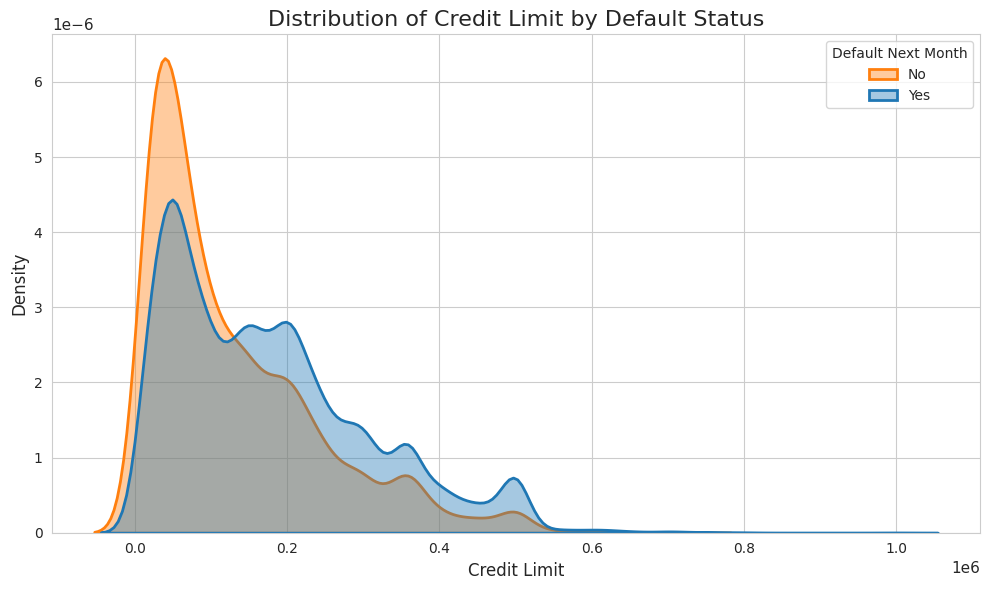

In [17]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df, x="LIMIT_BAL", hue="next_month_default", common_norm=False, fill=True, alpha=0.4, linewidth=2)
plt.title("Distribution of Credit Limit by Default Status", fontsize=16)
plt.xlabel("Credit Limit", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Default Next Month", labels=["No", "Yes"])
plt.tight_layout()
plt.show()
plt.clf()
plt.close()


- **Defaulters (Yes)**:  
  ◀**Left-shifted density peak**  
  - Indicates higher defaults at **lower credit limits**  
  - *Likely reason*: High credit utilization → financial stress  

- **Non-Defaulters (No)**:  
  ▶**Right-spread distribution**  
  - Wider limit range → more financial flexibility  

- **Low-limit borrowers** are at higher risk  
- **Limit amount** strongly predicts default probability  

- **Feature Engineering**:  
  - Added `utilization = (bill_amt / LIMIT_BAL)` later


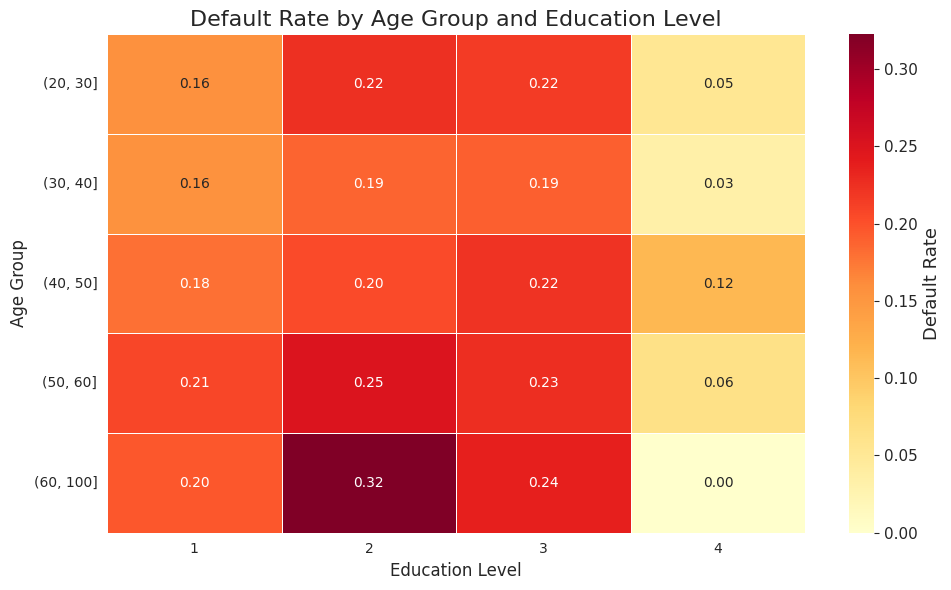

In [18]:
df['AGE_BIN'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 100])

cross_tab = pd.crosstab(df['AGE_BIN'], df['education'], values=df['next_month_default'], aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5, linecolor='white', cbar_kws={'label': 'Default Rate'})
plt.title("Default Rate by Age Group and Education Level", fontsize=16)
plt.xlabel("Education Level", fontsize=12)
plt.ylabel("Age Group", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()
plt.clf()
plt.close()

- **Least Educated (Level 4)**:  
  - **Lowest defaults** (0.00–0.12)  
  - Likely due to strict credit limits or conservative borrowing.  

- **More Educated (Levels 1-3)**:  
  - **Higher defaults** (up to 0.32)  
  - *Peak risk*: Ages 60+ in Level 2  
  - *Drivers*: Overleveraging, student loans, retirement income drop.  
- **NOTE: Level 4 is tiny, its low default rate may be skewed.**

<ipython-input-19-102475865>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate = df.groupby('LIMIT_BIN')['next_month_default'].mean().reset_index()
<ipython-input-19-102475865>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=default_rate, x='next_month_default', y='LIMIT_BIN', palette='mako')


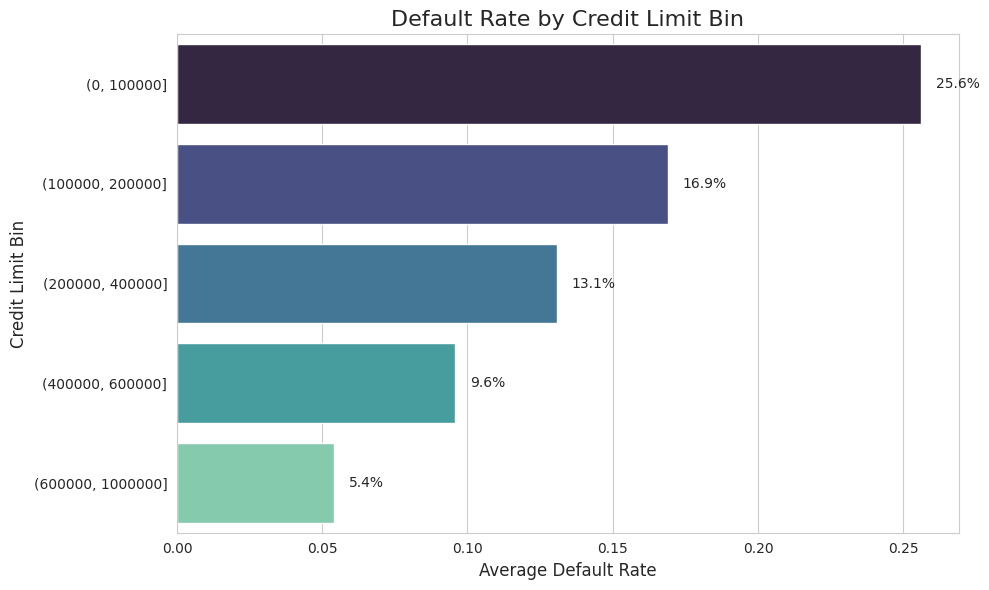

In [19]:
df['LIMIT_BIN'] = pd.cut(df['LIMIT_BAL'], bins=[0, 100000, 200000, 400000, 600000, 1000000])
default_rate = df.groupby('LIMIT_BIN')['next_month_default'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=default_rate, x='next_month_default', y='LIMIT_BIN', palette='mako')
plt.xlabel('Average Default Rate', fontsize=12)
plt.ylabel('Credit Limit Bin', fontsize=12)
plt.title('Default Rate by Credit Limit Bin', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for i, row in default_rate.iterrows():
    plt.text(row['next_month_default'] + 0.005, i, f"{row['next_month_default']:.1%}", va='center', fontsize=10)

plt.tight_layout()
plt.show()
plt.clf()
plt.close()

  **Higher limits → Lower defaults**  
  - (0-100K): **25.6%** default rate  
  - (600K-1M): **5.4%** default rate  

- **Risk Thresholds**:  
  **Critical zone**: <200K limit (~16.9-25.6% defaults)  
  **Safe zone**: >400K limit (<10% defaults)  

#### Why This Matters  
- **Low-limit borrowers**:  
  - Likely face higher credit utilization  
  - May represent higher-risk customer segments  

#### Feature Engineering
  - Added `limit_bin` categorical feature  



<ipython-input-20-3970336130>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  util_defaults = df.groupby('util_bin')['next_month_default'].mean().reset_index()
<ipython-input-20-3970336130>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=util_defaults, x='util_bin', y='next_month_default', palette='crest')


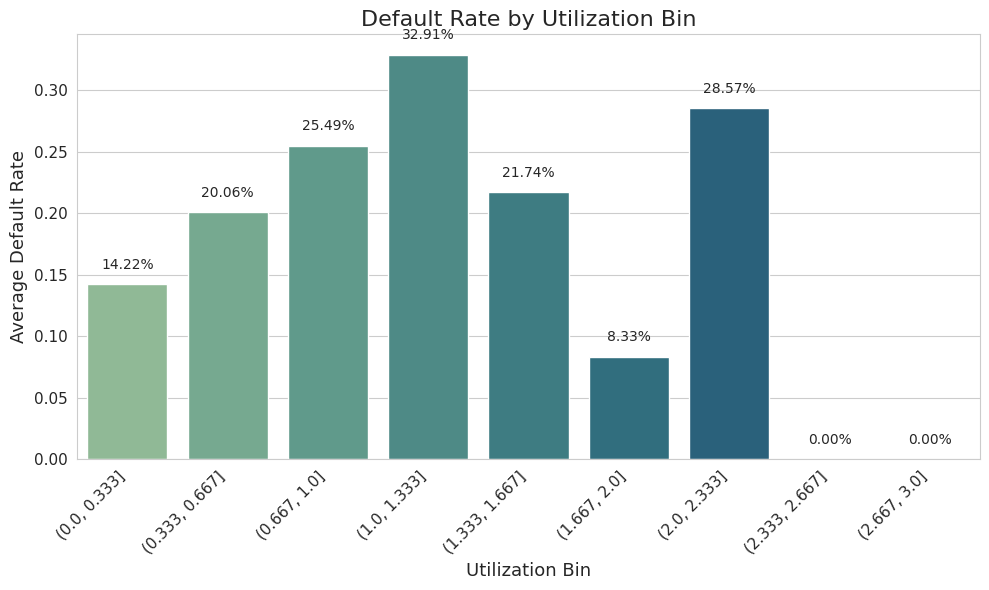

In [20]:
#Created the utilization fearture here
df['utilization'] = df['AVG_Bill_amt'] / df['LIMIT_BAL']
df_test['utilization'] = df_test['AVG_Bill_amt'] / df['LIMIT_BAL']
df['util_bin'] = pd.cut(df['utilization'], bins=np.linspace(0, 3, 10))
util_defaults = df.groupby('util_bin')['next_month_default'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=util_defaults, x='util_bin', y='next_month_default', palette='crest')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Utilization Bin')
plt.ylabel('Average Default Rate')
plt.title('Default Rate by Utilization Bin')

for i, row in util_defaults.iterrows():
    plt.text(i, row['next_month_default'] + 0.01, f"{row['next_month_default']:.2%}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
plt.clf()
plt.close()

# Cluster-Based Customer Segmentation
*Identified distinct borrower profiles using k-means clustering and elbow method on repayment behavior, credit usage, and demographic features.*

###Repayment Cluster

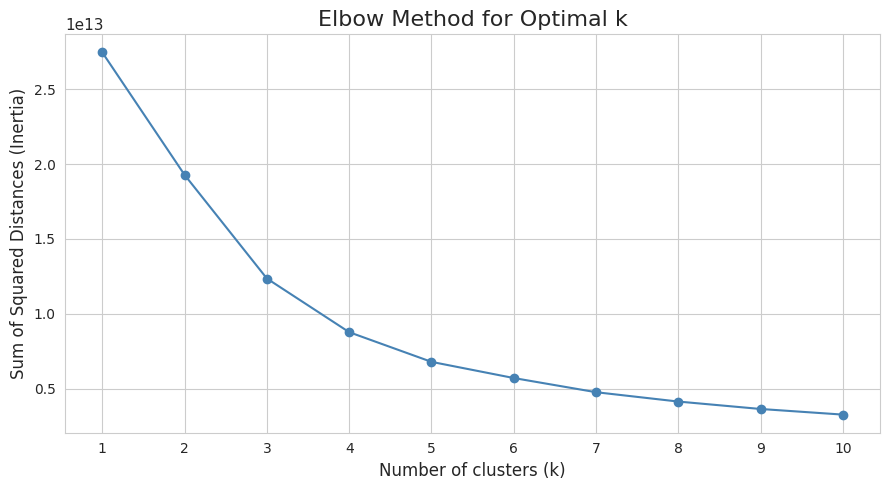

In [21]:
payment_columns = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
payment_sequences = df[payment_columns]
pca = PCA(n_components=2)
repayment_embedded = pca.fit_transform(payment_sequences)

sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(repayment_embedded)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(9, 5))
plt.plot(k_range, sse, marker='o', linestyle='-', color='steelblue')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Sum of Squared Distances (Inertia)', fontsize=12)
plt.xticks(k_range, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()
plt.close()


##K=4

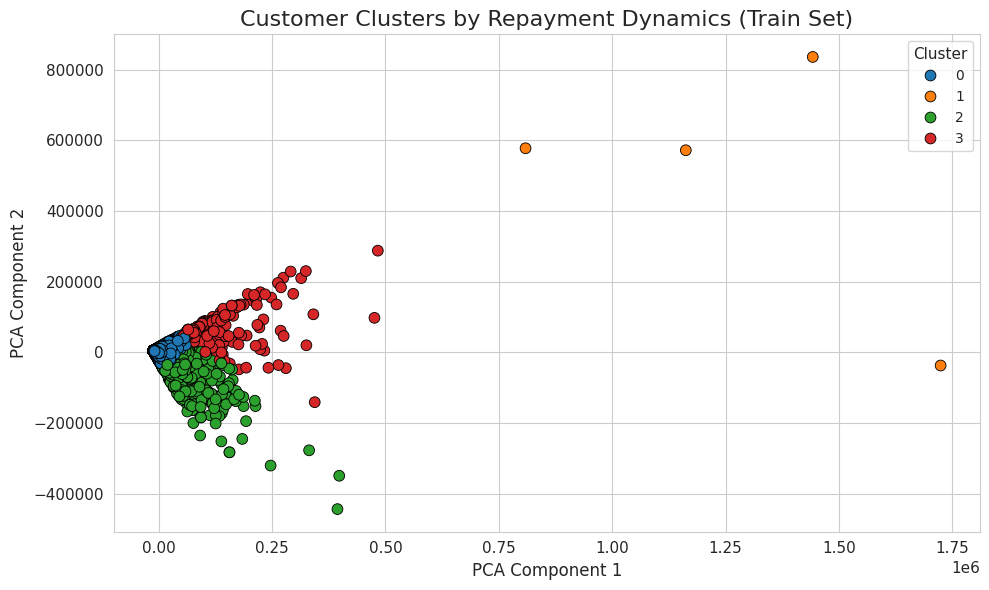

In [22]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(repayment_embedded)

df['repayment_cluster'] = clusters
df['pca1'] = repayment_embedded[:, 0]
df['pca2'] = repayment_embedded[:, 1]

test_payment_sequences = df_test[payment_columns]
test_repayment_embedded = pca.transform(test_payment_sequences)
test_clusters = kmeans.predict(test_repayment_embedded)

df_test['repayment_cluster'] = test_clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='repayment_cluster', palette='tab10', s=60, edgecolor='k')
plt.title('Customer Clusters by Repayment Dynamics (Train Set)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Cluster', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()
plt.clf()
plt.close()


<ipython-input-23-3035939951>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_defaults, x='repayment_cluster', y='next_month_default', palette='viridis')


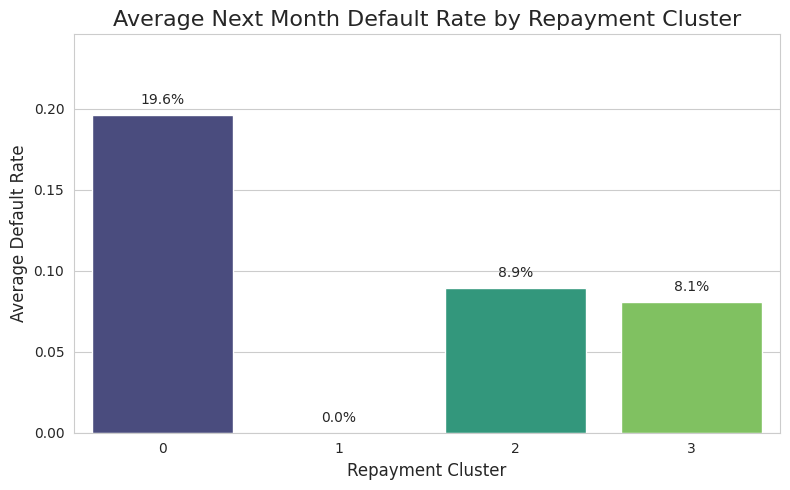

In [23]:
cluster_defaults = df.groupby('repayment_cluster')['next_month_default'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_defaults, x='repayment_cluster', y='next_month_default', palette='viridis')
plt.xlabel('Repayment Cluster', fontsize=12)
plt.ylabel('Average Default Rate', fontsize=12)
plt.title('Average Next Month Default Rate by Repayment Cluster', fontsize=16)
plt.ylim(0, cluster_defaults['next_month_default'].max() + 0.05)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for i, row in cluster_defaults.iterrows():
    plt.text(i, row['next_month_default'] + 0.005, f"{row['next_month_default']:.1%}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
plt.clf()
plt.close()

### Cluster Risk Analysis

#### Highest Default Cluster (0)
#### Lowest Default Cluster (1)  


### Credit Usage Cluster

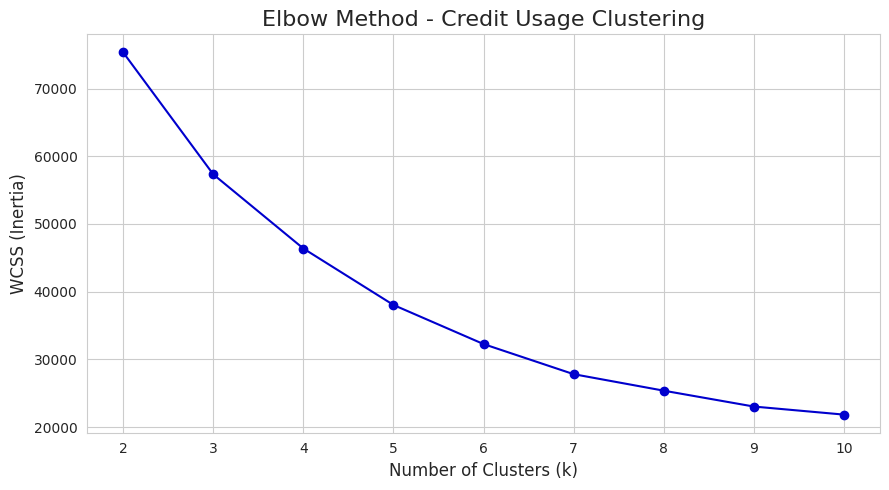

In [24]:
credit_usage_features = ['utilization', 'bill_limit_ratio', 'AVG_Bill_amt',
                         'PAY_TO_BILL_ratio', 'missed_payments']
credit_usage_data = df[credit_usage_features].dropna()
scaler = StandardScaler()
credit_scaled = scaler.fit_transform(credit_usage_data)

wcss_credit = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(credit_scaled)
    wcss_credit.append(kmeans.inertia_)

plt.figure(figsize=(9, 5))
plt.plot(K_range, wcss_credit, 'o-', color='mediumblue')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS (Inertia)', fontsize=12)
plt.title('Elbow Method - Credit Usage Clustering', fontsize=16)
plt.xticks(K_range, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.clf()
plt.close()

##K=5

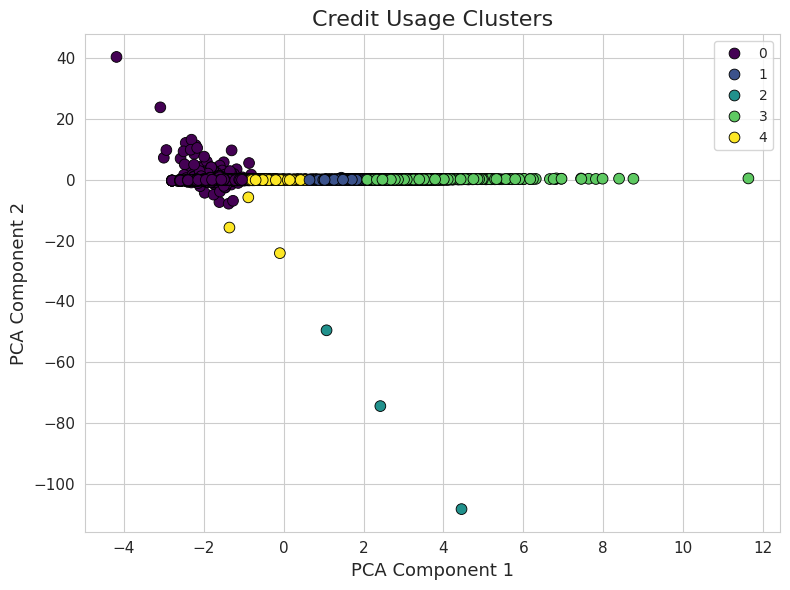

In [25]:
credit_usage_data = df[credit_usage_features].dropna()
scaler = StandardScaler()
credit_scaled = scaler.fit_transform(credit_usage_data)
pca = PCA(n_components=2)
credit_pca = pca.fit_transform(credit_scaled)
kmeans_credit = KMeans(n_clusters=5, random_state=42)
credit_clusters = kmeans_credit.fit_predict(credit_pca)
df['credit_usage_cluster'] = -1
df.loc[credit_usage_data.index, 'credit_usage_cluster'] = credit_clusters

credit_usage_data_test = df_test[credit_usage_features].dropna()
credit_scaled_test = scaler.transform(credit_usage_data_test)
credit_pca_test = pca.transform(credit_scaled_test)
credit_clusters_test = kmeans_credit.predict(credit_pca_test)
df_test['credit_usage_cluster'] = -1
df_test.loc[credit_usage_data_test.index, 'credit_usage_cluster'] = credit_clusters_test

plt.figure(figsize=(8, 6))
sns.scatterplot(x=credit_pca[:, 0], y=credit_pca[:, 1], hue=credit_clusters, palette='viridis', s=60, edgecolor='k')
plt.title("Credit Usage Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

<ipython-input-26-4256654480>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_defaults, x='credit_usage_cluster', y='next_month_default', palette='viridis')


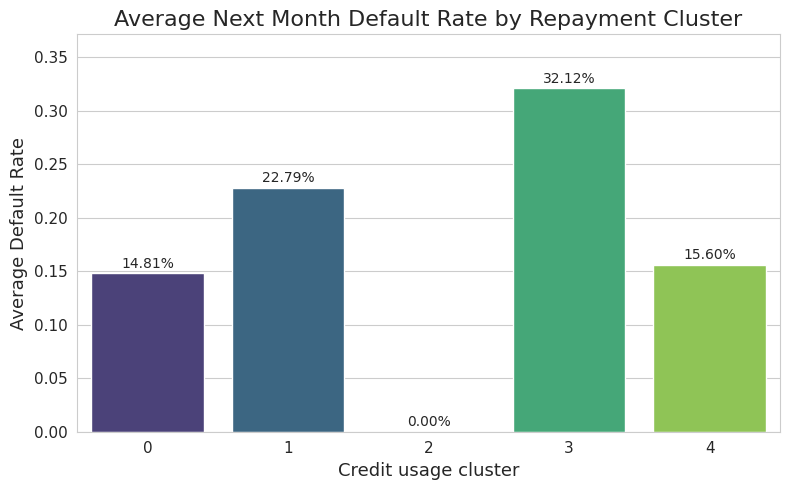

In [26]:
cluster_defaults = df.groupby('credit_usage_cluster')['next_month_default'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_defaults, x='credit_usage_cluster', y='next_month_default', palette='viridis')
plt.xlabel('Credit usage cluster')
plt.ylabel('Average Default Rate')
plt.title('Average Next Month Default Rate by Repayment Cluster')
plt.ylim(0, cluster_defaults['next_month_default'].max() + 0.05)

for i, row in cluster_defaults.iterrows():
    plt.text(i, row['next_month_default'] + 0.005,
             f"{row['next_month_default']:.2%}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Cluster Risk Analysis

#### Highest Default Cluster (3)
#### Lowest Default Cluster (2)  


### Demographic Cluster

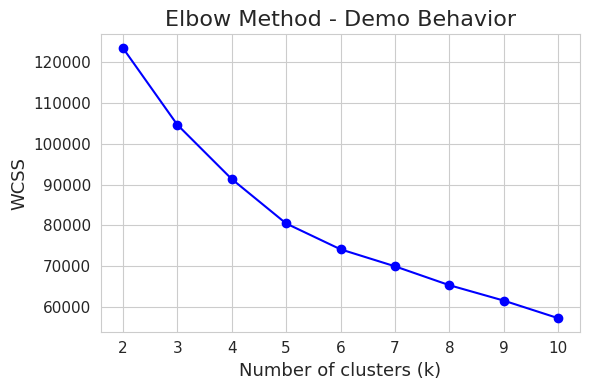

In [27]:
demo_features = ['age', 'education', 'marriage', 'LIMIT_BAL', 'AVG_PAY_amt', 'utilization']

demo_data = df[demo_features].dropna()
demo_scaled = scaler.fit_transform(demo_data)

wcss_demo = []
silhouette_scores_demo = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(demo_scaled)
    wcss_demo.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, wcss_demo, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method - Demo Behavior')
plt.tight_layout()
plt.show()

##K=6

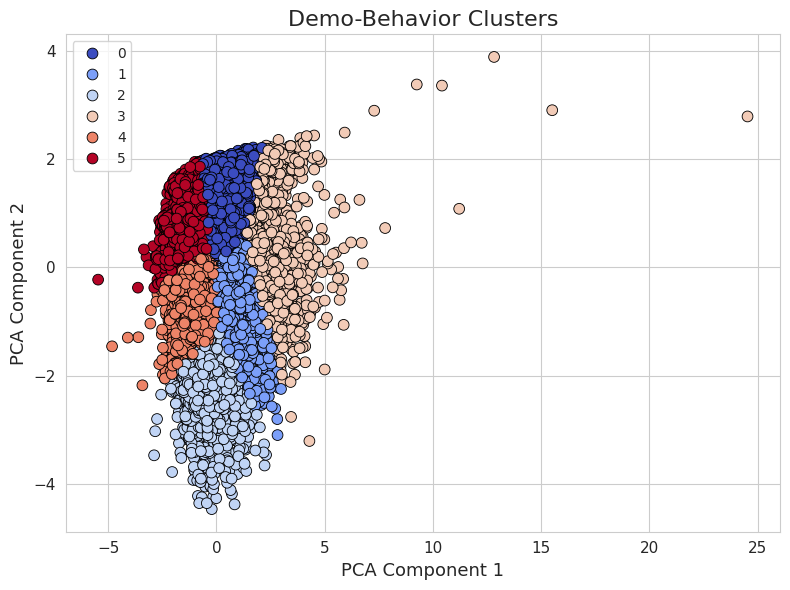

In [28]:
demo_features = ['age', 'education', 'marriage', 'LIMIT_BAL', 'AVG_PAY_amt', 'utilization']

demo_data = df[demo_features].dropna()
demo_scaled = scaler.fit_transform(demo_data)
demo_pca = PCA(n_components=2)
demo_pca_result = demo_pca.fit_transform(demo_scaled)
kmeans_demo = KMeans(n_clusters=6, random_state=42)
demo_clusters = kmeans_demo.fit_predict(demo_pca_result)
df['demo_behavior_cluster'] = -1
df.loc[demo_data.index, 'demo_behavior_cluster'] = demo_clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(x=demo_pca_result[:, 0], y=demo_pca_result[:, 1], hue=demo_clusters, palette='coolwarm', s=60, edgecolor='k')
plt.title("Demo-Behavior Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

demo_data_test = df_test[demo_features].dropna()
demo_scaled_test = scaler.transform(demo_data_test)
demo_pca_result_test = demo_pca.transform(demo_scaled_test)
demo_clusters_test = kmeans_demo.predict(demo_pca_result_test)
df_test['demo_behavior_cluster'] = -1
df_test.loc[demo_data_test.index, 'demo_behavior_cluster'] = demo_clusters_test


<ipython-input-29-2323687868>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_defaults, x='demo_behavior_cluster', y='next_month_default', palette='viridis')


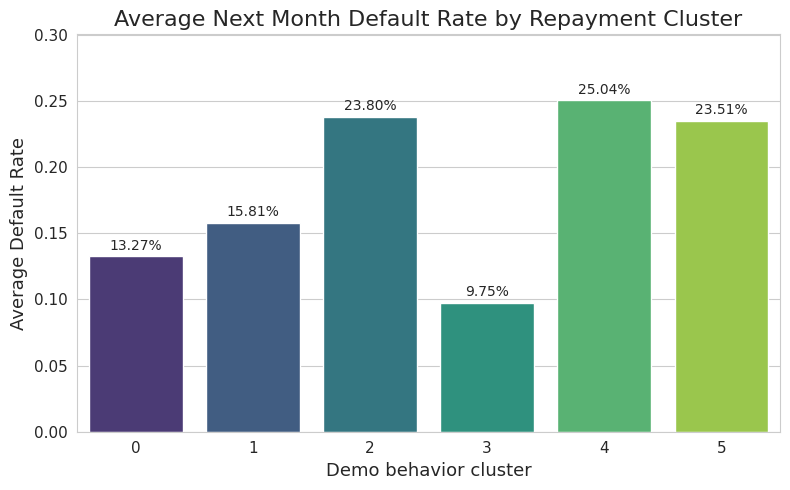

In [29]:
cluster_defaults = df.groupby('demo_behavior_cluster')['next_month_default'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_defaults, x='demo_behavior_cluster', y='next_month_default', palette='viridis')
plt.xlabel('Demo behavior cluster')
plt.ylabel('Average Default Rate')
plt.title('Average Next Month Default Rate by Repayment Cluster')
plt.ylim(0, cluster_defaults['next_month_default'].max() + 0.05)

for i, row in cluster_defaults.iterrows():
    plt.text(i, row['next_month_default'] + 0.005,
             f"{row['next_month_default']:.2%}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Cluster Risk Analysis

#### Highest Default Cluster (4)
#### Lowest Default Cluster (3)  

In [30]:
df.drop(['AGE_BIN','util_bin','pca1','pca2','LIMIT_BIN'],axis=1,inplace=True)

# Final Feature Engineering

## Payment Behavior Features
- **`payment_std`**: Standard deviation of last 6 payments → measures payment volatility  
- **`max_delay`**: Worst payment delay across 6 months → identifies chronic late-payers  
- **`avg_delay`**: Average payment delay → general repayment reliability  
- **`count_delay`**: Months with delayed payments → frequency of late payments  
- **`payment_cv`**: Coefficient of variation (std/mean) → normalized payment instability  
- **`no_payment_flag`**: No payment in latest month → potential financial distress  
- **`new_activity_flag`**: New payment after inactivity → possible re-engagement  

## Billing Patterns  
- **`bill_std`**: Standard deviation of bills → spending volatility  
- **`bill_cv`**: Coefficient of variation for bills → normalized spending instability  
- **`bill_trend_dir`**: Binary trend direction (1=upward, 0=downward) → spending momentum  
- **`recent_bill_spike`**: Latest bill vs average → sudden spending changes  
- **`limit_util_peak`**: Peak utilization (max bill/limit) → worst-case credit strain  

## Interaction Features  
- **`pay_delay_x_util`**: Max delay × utilization → compound risk score  
- **`bill_trend_x_util`**: Bill trend × utilization → spending growth under pressure  
- **`avg_delay_x_util`**: Avg delay × utilization → habitual risk indicator  

## Implementation Notes  
- Applied identical transformations to train/test sets (`df` and `df_test`)  
- Added `1e-5` to denominators to prevent division by zero  
- All features designed to be **interpretable**  

In [31]:
df['payment_std'] = df[[f'pay_amt{i}' for i in range(1, 7)]].std(axis=1)
df_test['payment_std'] = df_test[[f'pay_amt{i}' for i in range(1, 7)]].std(axis=1)

df['bill_std'] = df[[f'Bill_amt{i}' for i in range(1, 7)]].std(axis=1)
df_test['bill_std'] = df_test[[f'Bill_amt{i}' for i in range(1, 7)]].std(axis=1)

pay_cols = [f'pay_{i}' for i in [0,2,3,4,5,6]]
df['max_delay'] = df[pay_cols].max(axis=1)
df_test['max_delay'] = df_test[pay_cols].max(axis=1)

df['avg_delay'] = df[pay_cols].mean(axis=1)
df_test['avg_delay'] = df_test[pay_cols].mean(axis=1)

df['count_delay'] = df[pay_cols].apply(lambda row: (row > 0).sum(), axis=1)
df_test['count_delay'] = df_test[pay_cols].apply(lambda row: (row > 0).sum(), axis=1)

df['pay_delay_x_util']=df['max_delay']*df['utilization']
df_test['pay_delay_x_util']=df_test['max_delay']*df['utilization']

df['bill_cv'] = df['bill_std'] / (df['AVG_Bill_amt'] + 1e-5)
df_test['bill_cv'] = df_test['bill_std'] / (df_test['AVG_Bill_amt'] + 1e-5)

df['payment_cv'] = df['payment_std'] / (df['AVG_PAY_amt'] + 1e-5)
df_test['payment_cv'] = df_test['payment_std'] / (df_test['AVG_PAY_amt'] + 1e-5)

df['bill_trend_x_util'] = df['bill_trend'] * df['utilization']
df_test['bill_trend_x_util'] = df_test['bill_trend'] * df_test['utilization']

df['bill_trend_dir'] = (df['bill_trend'] > 0).astype(int)
df_test['bill_trend_dir'] = (df_test['bill_trend'] > 0).astype(int)

df['recent_bill_spike']=df['Bill_amt6'] / (df['AVG_Bill_amt'] + 1e-5)
df_test['recent_bill_spike']=df_test['Bill_amt6'] / (df['AVG_Bill_amt'] + 1e-5)

df['limit_util_peak'] = df[['Bill_amt4', 'Bill_amt5', 'Bill_amt6']].max(axis=1) / df['LIMIT_BAL']
df_test['limit_util_peak'] = df_test[['Bill_amt4', 'Bill_amt5', 'Bill_amt6']].max(axis=1) / df_test['LIMIT_BAL']

df['avg_delay_x_util']=df['avg_delay']*df['utilization']
df_test['avd_delay_x_util']=df_test['avg_delay']*df_test['utilization']

df['no_payment_flag']=(df['pay_amt6']==0).astype(int)
df_test['no_payment_flag']=(df_test['pay_amt6']==0).astype(int)

df['new_activity_flag'] = ((df['pay_amt6'] > 0) & (df['pay_amt5'] == 0)).astype(int)
df_test['new_activity_flag'] = ((df_test['pay_amt6'] > 0) & (df_test['pay_amt5'] == 0)).astype(int)

In [32]:
#For handling the imbalance in the dataset
X = df.drop('next_month_default', axis=1)
y = df['next_month_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

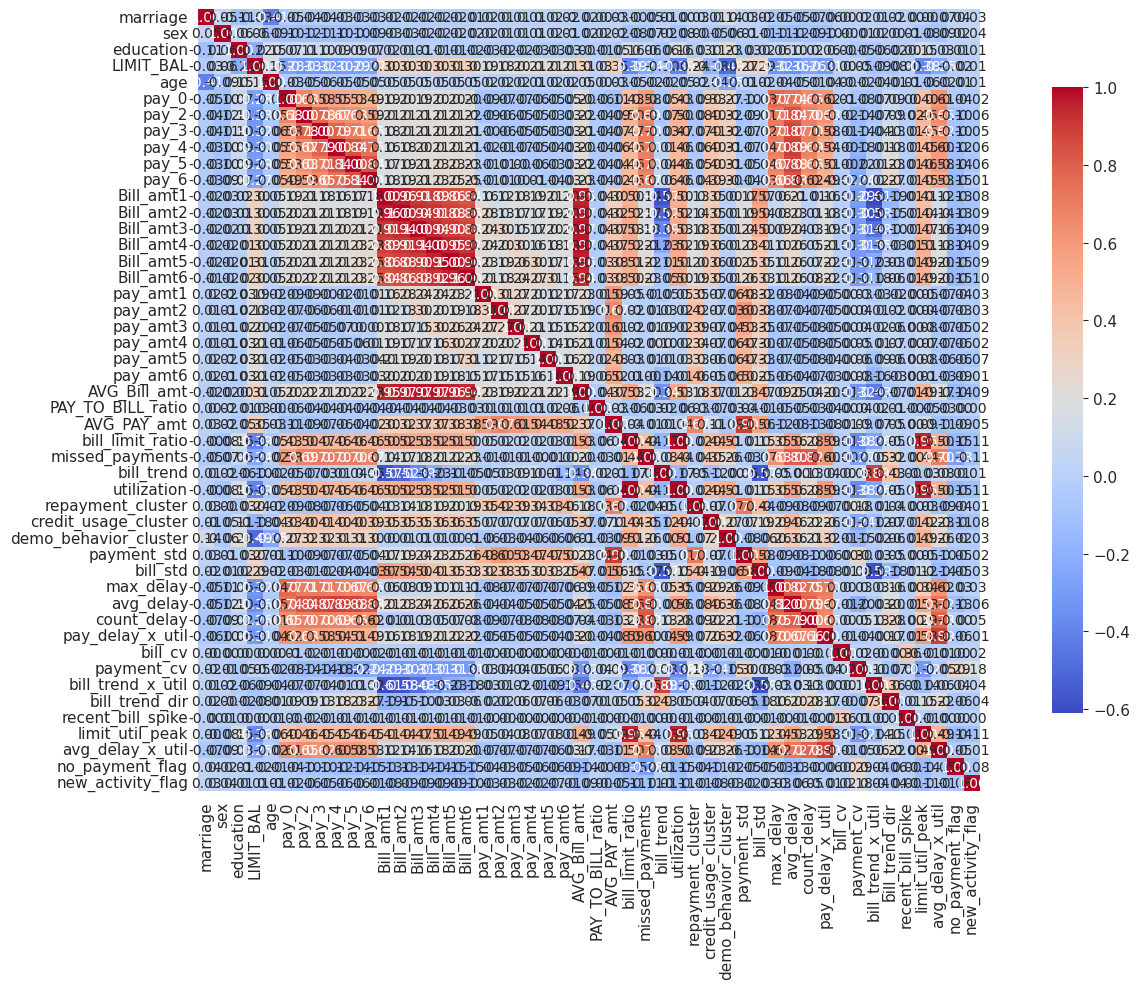

In [33]:
# Finding correlation among different features of the dataset
corr = X_train_smote.corr(numeric_only=True)
plt.figure(figsize=(15, 10))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.tight_layout()
plt.show()

# Feature Selection Rationale

## 1. Handling Multicollinearity

### Identified via Correlation Heatmaps
- High correlation observed between the following among themselves and each other:
  - Original features (`pay_0`, `pay_amt0`, `bill_amt0`, etc.)
  - Derived features (`count_delay`, `avg_delay`, `avg_delay_x_util`, etc.)
  
**Example**:  
`pay_0` (delinquency status) strongly correlates with `count_delay` (aggregated delay count).

### Action Taken
Retained correlated features despite multicollinearity because:
- **Tree-based models** (XGBoost, Random Forest) are robust to multicollinearity:
  - Splits are made independently on features.
- **Derived features** may capture higher-order patterns:
  - `avg_delay_x_util` could reveal interaction effects missed by raw features.

---

## 2. Feature Dropping via Iterative SHAP Analysis

### Methodology
1. Conducted **extensive trial-and-error experiments** (15+ iterations) with SHAP analysis:
   - Systematically ranked features by importance across multiple runs
   - Tested performance impact of dropping each low-SHAP feature
2. Finalized features through **empirical validation**:
   - Only kept modifications that consistently improved metrics
   - Verified stability across different random seeds

### Outcome
- **Significant Improvements**:
  - Removed 15+ low-SHAP features including:
    - `repayment_cluster`, `utilization`
    - Redundant payment features (`pay_5`, `pay_6`, `AVG_PAY_amt`)
    - Low-impact bill stats (`Bill_amt2-6`, `bill_std`, `payment_std`)
    - Engineered features (`credit_usage_cluster`, `bill_trend`)
  - **Result**: Consistent ↑ in both Accuracy and F2 score

### Justification
- **Tree-Specific Optimization**:
  - Focused on reducing noise, not fixing multicollinearity
  - SHAP values revealed truly impactful features
- **Overfitting Prevention**:
  - Used multiple validation sets to confirm improvements
  - Maintained feature diversity while removing redundancy

---

## Key Takeaways

- **Rigorous Experimentation**:
  - 15+ iterations of SHAP analysis and feature testing
  - Every decision backed by empirical evidence
- **Tree-Specific Advantages**:
  - Leveraged algorithm's natural resistance to multicollinearity
- **Metrics-Driven Results**:
  - F2 score improvements validated the approach
  - No "theoretical purity" - only what worked mattered
- **Lessons Learned**:
  - Some engineered features (`credit_usage_cluster`) added complexity without value
  - Raw features often outperformed overly-specific derived ones

In [34]:
cols_to_drop = (
    ['repayment_cluster', 'utilization','pay_5','pay_6','Bill_amt2','Bill_amt4','Bill_amt6','credit_usage_cluster','Bill_amt5','bill_std','payment_std','Bill_amt3','bill_trend','pay_2','AVG_PAY_amt']
)
X_train_smote.drop(columns=cols_to_drop, inplace=True)
X_test.drop(columns=cols_to_drop, inplace=True)
df_test.drop(columns=cols_to_drop, inplace=True)

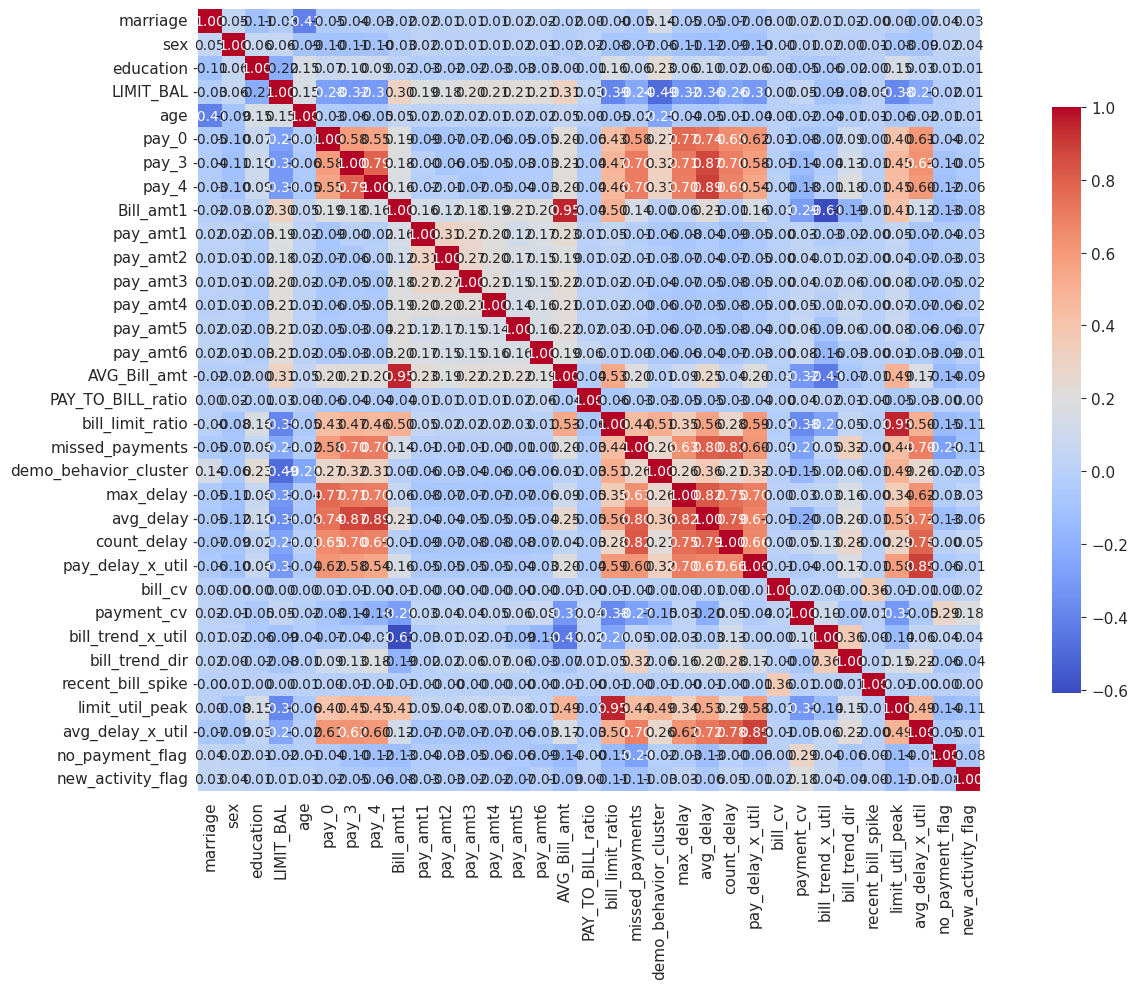

In [35]:
corr = X_train_smote.corr(numeric_only=True)
plt.figure(figsize=(15, 10))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", square=True, cbar_kws={"shrink": 0.75})
plt.tight_layout()
plt.show()

In [38]:
X = X_train_smote
y = y_train_smote

## Model Selection and Hyperparameter Tuning with GridSearchCV

Applying `GridSearchCV` across a dictionary of models, each with its own hyperparameter grid, to identify the best-performing model and optimal configuration using cross-validation.


In [39]:
random_state = 42
model_grid = {
    "RandomForest": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [100],
            "max_depth": [5, None],
            "max_features": ["sqrt"]
        }
    },

    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [100],
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 6]
        }
    },

    "LightGBM": {
        "model": LGBMClassifier(random_state=42),
        "params": {
            "n_estimators": [100],
            "learning_rate": [0.05, 0.1],
            "max_depth": [5, 10]
        }
    },

    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            "iterations": [100],
            "learning_rate": [0.05, 0.1],
            "depth": [6]
        }
    }
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, mp in model_grid.items():
    print(f"\nRunning GridSearchCV for {name}...")

    clf = GridSearchCV(mp['model'], mp['params'], cv=skf, scoring='accuracy', n_jobs=-1)
    clf.fit(X, y)

    print(f"Best params for {name}: {clf.best_params_}")
    print(f"Best accuracy: {clf.best_score_:.4f}")


Running GridSearchCV for RandomForest...
Best params for RandomForest: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Best accuracy: 0.8859

Running GridSearchCV for XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:06:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best accuracy: 0.8741

Running GridSearchCV for LightGBM...
[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5182
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best params for LightGBM: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Best accuracy: 0.8788

Running GridSearchCV for CatBoost...
Best params for CatBoost: {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
Best accuracy: 0.8610


## LightGBM Optimization with Optuna

Initial `GridSearchCV` results indicated that LightGBM outperformed other models, prompting extensive hyperparameter tuning using Optuna. A broad search space was defined to effectively explore optimal configurations. Although various ensembling methods, including stacking and bagging, were also attempted, none yielded better results than standalone LightGBM.

In [41]:
def objective(trial, X, y):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 15, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 20),
        'n_estimators': 1000,
        'random_state': 42,
        'verbosity': -1
    }

    acc_scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="binary_logloss",
            callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)]
        )

        y_pred = model.predict(X_valid)
        acc = accuracy_score(y_valid, y_pred)
        acc_scores.append(acc)

    return np.mean(acc_scores)

In [42]:
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(lambda trial: objective(trial, X.values, y.values), n_trials=50)

print("Best Accuracy:", study.best_value)
print("Best Params:", study.best_params)

In [43]:
#Stored the parameters cause computation took long during multiple runs.
best_params={'learning_rate': 0.05145895696727499,
 'num_leaves': 77,
 'max_depth': 11,
 'min_child_samples': 9,
 'subsample': 0.7487719431679569,
 'colsample_bytree': 0.6620802937730577,
 'reg_alpha': 2.256289051478411,
 'reg_lambda': 6.214742337504001,
 'scale_pos_weight': 1.022450188734329}

final_model = LGBMClassifier(**best_params)
final_model.fit(X, y)

[LightGBM] [Info] Number of positive: 16352, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5182
[LightGBM] [Info] Number of data points in the train set: 32704, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(colsample_bytree=0.6620802937730577,
               learning_rate=0.05145895696727499, max_depth=11,
               min_child_samples=9, num_leaves=77, reg_alpha=2.256289051478411,
               reg_lambda=6.214742337504001, scale_pos_weight=1.022450188734329,
               subsample=0.7487719431679569)

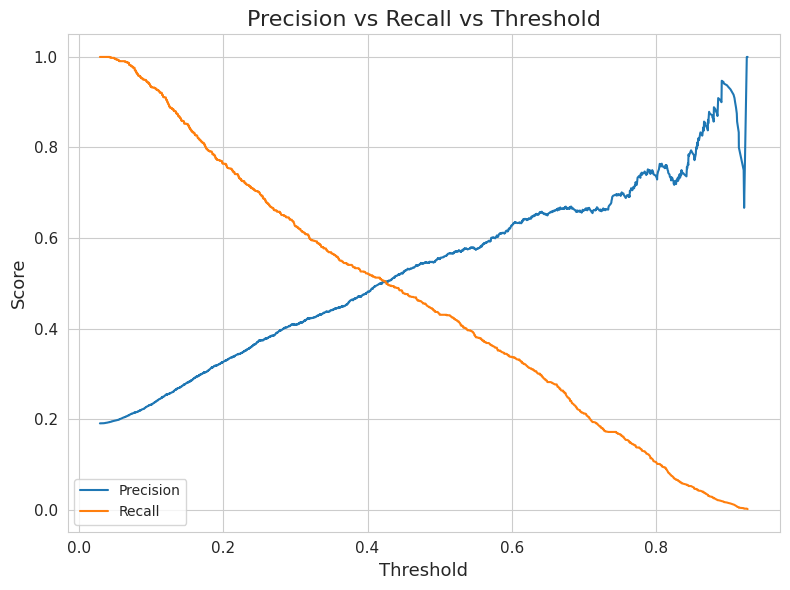

In [44]:
y_proba = final_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds, precision[:-1], label='Precision')
ax.plot(thresholds, recall[:-1], label='Recall')
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_title("Precision vs Recall vs Threshold")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
plt.clf()
plt.close()

## Cross-Validated Threshold Tuning for F2 Optimization

To optimize for the F2-score, which emphasizes recall, we follow these steps:

### 1. Generate Out-of-Fold (OOF) Predictions
Using 5-fold `StratifiedKFold`, we train the LightGBM model (with tuned hyperparameters) and store validation probabilities in `oof_preds`. This ensures each prediction comes from a model that hasn't seen the sample during training.

### 2. Tune Classification Threshold
Instead of using a default 0.5 threshold, we compute precision and recall across thresholds using `precision_recall_curve`. The F2-score is then calculated as:

$$
F_{\beta} = \frac{(1 + \beta^2) \cdot \text{precision} \cdot \text{recall}}{(\beta^2 \cdot \text{precision}) + \text{recall} + \varepsilon}
$$

We select the threshold that maximizes the F2-score, ensuring optimal performance for recall-focused tasks.


In [45]:
oof_preds = np.zeros(len(X))
y_true = np.array(y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    f2_model = LGBMClassifier(**best_params)
    f2_model.fit(X_train, y_train)
    oof_preds[valid_idx] = f2_model.predict_proba(X_valid)[:, 1]


precision, recall, thresholds = precision_recall_curve(y_true, oof_preds)

def f2_score(precision, recall, beta=2):
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-8)

f2_scores = f2_score(precision, recall, beta=2)
best_thresh = thresholds[np.argmax(f2_scores)]

print("Best threshold from CV:", best_thresh)

[LightGBM] [Info] Number of positive: 13082, number of negative: 13081
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5177
[LightGBM] [Info] Number of data points in the train set: 26163, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500019 -> initscore=0.000076
[LightGBM] [Info] Start training from score 0.000076
[LightGBM] [Info] Number of positive: 13082, number of negative: 13081
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5179
[LightGBM] [Info] Number of data points in the train set: 26163, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500019 -> initscore=0.000076
[LightGBM] [Info] Start training from score 0.000076
[LightGBM] [Info

Test set accuracy: 0.6938613861386138
Test set AUC: 0.7773624237665334
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.69      0.78      4088
           1       0.35      0.72      0.47       962

    accuracy                           0.69      5050
   macro avg       0.63      0.70      0.63      5050
weighted avg       0.81      0.69      0.72      5050



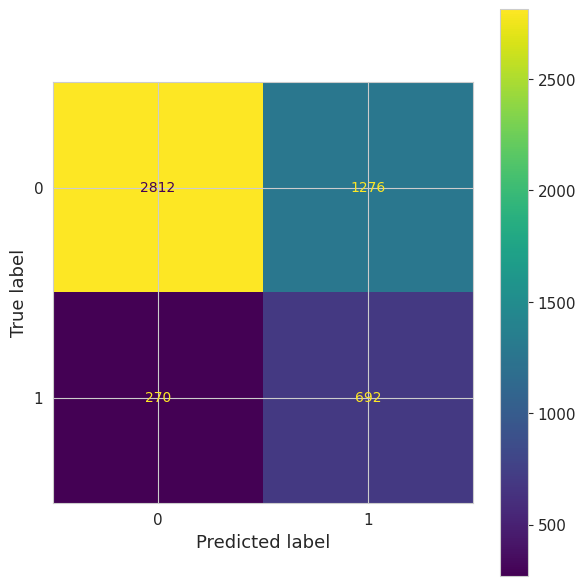

In [46]:
y_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > best_thresh).astype(int)
auc = roc_auc_score(y_test, y_proba)
test_accuracy = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred, output_dict=False)
conf_mat = confusion_matrix(y_test, y_pred)

print("Test set accuracy:", test_accuracy)
print("Test set AUC:", auc)
print("Classification Report:")
print(cr)

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(ax=ax)
plt.tight_layout()
plt.show()
plt.clf()
plt.close()

In [47]:
f2 = fbeta_score(y_test, y_pred, beta=2)

fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = f2,
    number = {'valueformat': '.4f'},
    title = {'text': "F2 Score"},
    gauge = {
        'axis': {'range': [0, 1]},
        'bar': {'color': "darkblue"},
        'steps': [
            {'range': [0, 0.5], 'color': "red"},
            {'range': [0.5, 0.8], 'color': "orange"},
            {'range': [0.8, 1], 'color': "green"}
        ],
    }
))
fig.update_layout(
    width=300,
    height=250,
    margin=dict(t=50, b=0, l=0, r=0)
)
fig.show()

## SHAP-Based Model Interpretation

The SHAP analysis provides both global and local interpretability for the LightGBM model:

- **Top Plot (Beeswarm Summary)**:
  - `pay_delay_x_util`, `avg_delay`, and `marriage` are the most impactful features across predictions.
  - High values of `pay_delay_x_util` (e.g., high utilization during delayed payments) push the model toward negative predictions.
  - `sex` and `missed_payments` also show moderate influence, indicating behavioral and demographic signals matter.

- **Bottom Plot (Waterfall for Prediction 0)**:
  - For this instance, `pay_delay_x_util` contributes the most negatively (−1.5), significantly lowering the predicted probability.
  - Other features like `avg_delay`, `max_delay`, and `count_delay` further push the prediction down, indicating high credit risk.
  - A few features (e.g., `marriage = 2`, `AVG_Bill_amt`) contribute positively but are outweighed.

This analysis highlights how late payment behavior and delay metrics are key drivers in the model's risk assessment.



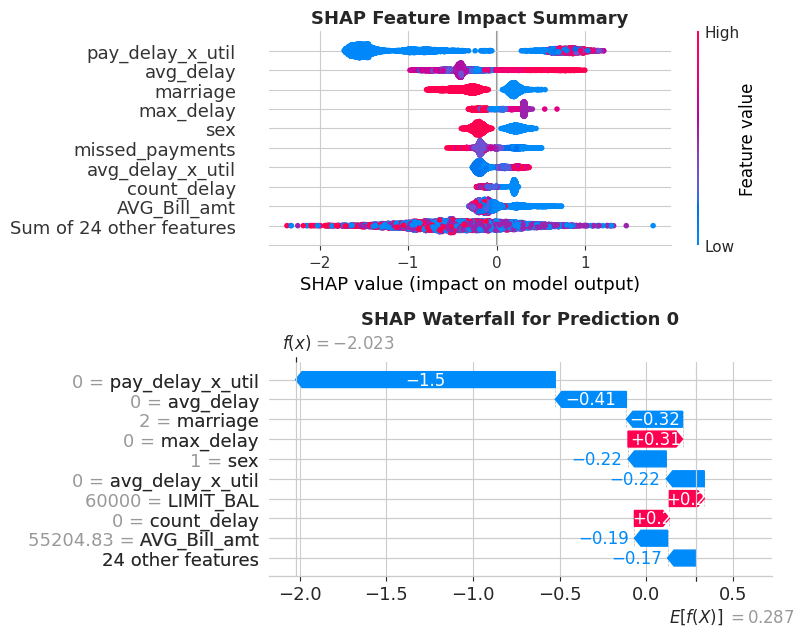

In [48]:
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 11,
    'axes.labelcolor': 'black',
    'axes.titlesize': 13,
    'axes.titleweight': 'bold'
})

explainer = shap.Explainer(final_model)
shap_values = explainer(X_test)

fig = plt.figure(figsize=(10, 12))

ax1 = plt.subplot2grid((2, 1), (0, 0))
shap.plots.beeswarm(shap_values, max_display=10, show=False)
plt.title("SHAP Feature Impact Summary")

plt.subplot2grid((2, 1), (1, 0))
shap.plots.waterfall(shap_values[0], show=False)
plt.title("SHAP Waterfall for Prediction 0")

plt.tight_layout()
plt.savefig("shap_combined_subplots.png", dpi=300)
plt.show()
plt.clf()
plt.close()

## SHAP Feature Importance (Mean Absolute Value)

This bar plot highlights the average impact of each feature on the model's output using SHAP values.

- `pay_delay_x_util`, `avg_delay`, and `marriage` emerged as the most influential predictors.
- Features such as `sex`, `missed_payments`, and billing-related delay metrics also contributed meaningfully.

> Note: This plot evolved over several iterations. Features with consistently low SHAP importance were dropped, but not blindly — removals were only finalized when cross-validation showed no adverse impact on F2-score or accuracy. This ensured a balance between interpretability and performance.




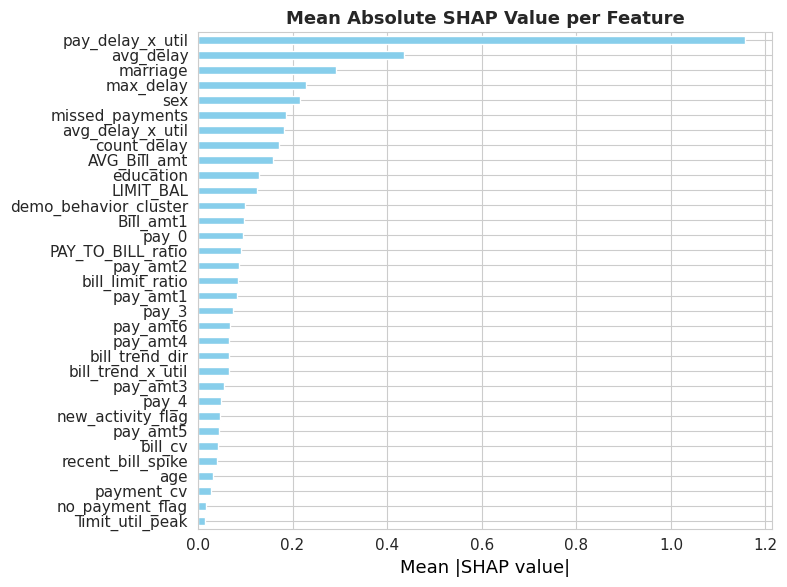

In [49]:
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
mean_abs_shap = shap_values_df.abs().mean().sort_values(ascending=True)

plt.figure(figsize=(8, 6))
mean_abs_shap.plot(kind='barh', color='skyblue')
plt.title("Mean Absolute SHAP Value per Feature")
plt.xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.show()

## SHAP Dependence Plots (All Features)

To better understand how individual features influence the model's output, SHAP dependence plots were generated for all features.

- These plots illustrate the marginal effect of each feature on the model prediction across its value range.
- By setting `interaction_index=None`, the plots show pure feature effects without forcing second-order interactions.
- This analysis helped verify monotonic trends, detect non-linear behavior, and validate that top features had interpretable relationships with the target.

Due to the number of features, a multi-subplot layout was used for clearer visualization.


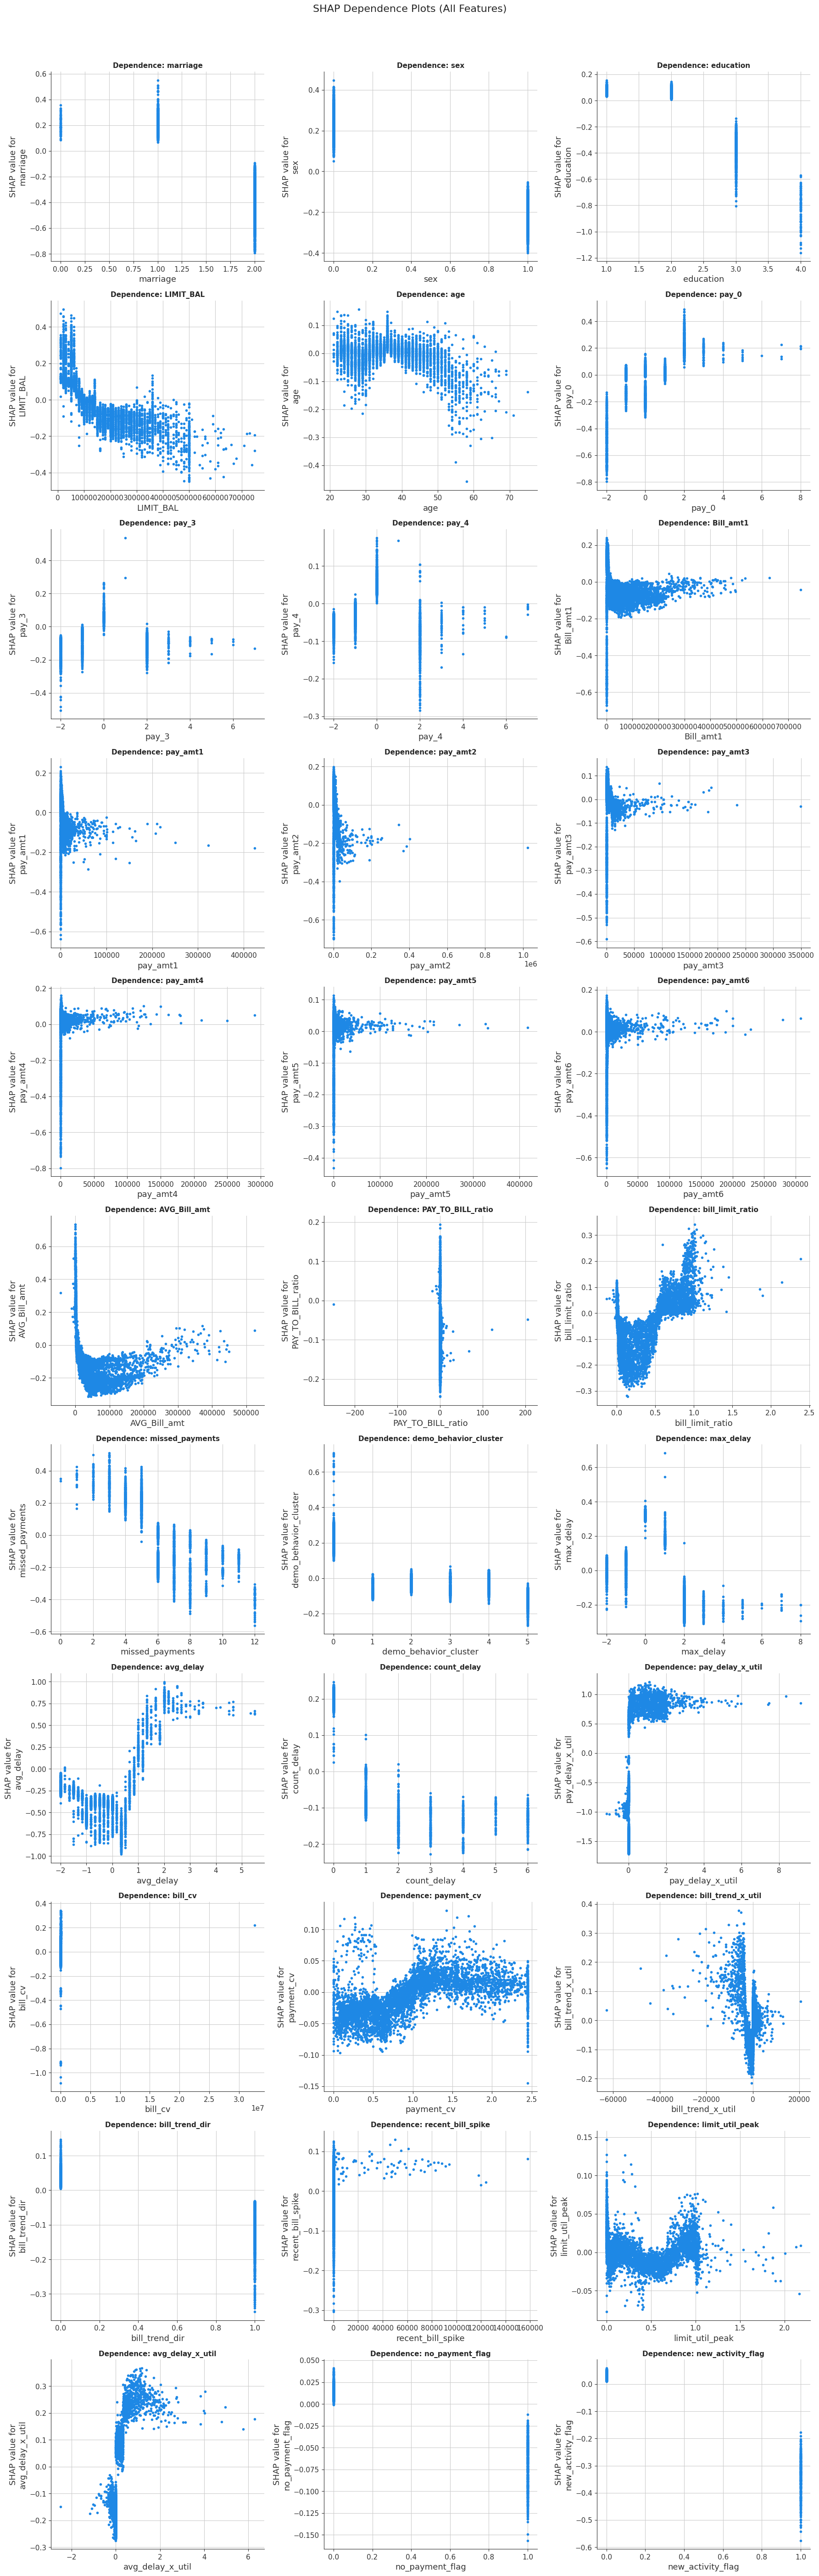

In [50]:
features = X_test.columns.tolist()
num_features = len(features)


cols = 3
rows = (num_features + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    plt.sca(axes[i])
    shap.dependence_plot(
        feature,
        shap_values.values,
        X_test,
        ax=axes[i],
        show=False,
        interaction_index=None
    )
    axes[i].set_title(f"Dependence: {feature}", fontsize=11)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("SHAP Dependence Plots (All Features)", fontsize=16, y=1.02)
plt.show()

# Surrogate Decision Tree Interpretation – Credit Default Model

## 1. Why Use a Surrogate Tree?

The original model likely uses non-linear relationships and complex interactions across many features. While it's accurate, it’s not transparent.

A **surrogate decision tree** is a simpler model trained on the same inputs and the outputs of the black-box model (not the ground truth). The goal here is not accuracy, but interpretability — to see what features the original model seems to rely on and how.

---

## 2. Overview of the Tree Structure

- The tree starts with a split on a custom feature called `pay_delay_x_util`, followed by splits on billing amounts, payment delays, and marital status.
- Each node is color-coded:
  - Orange nodes represent regions classified as **No Default**
  - Blue nodes are classified as **Default**
- The values shown at each node reflect:
  - `samples`: percentage of total data points reaching that node
  - `value`: count of `[No Default, Default]` instances at that node
  - `class`: predicted class by the tree

---

## 3. Key Splits and What They Mean

### 🔹 Root Node: `pay_delay_x_util ≤ 0.0`

- This is a custom feature that seems to combine **payment delays** with **credit utilization**.
- The tree puts this feature at the top, suggesting it's the most predictive.
- When this value is **less than or equal to zero**, the customer is predicted as **No Default**. Otherwise, there's a higher chance of default.

**Interpretation:**  
Customers who either pay on time or don't max out their credit are less likely to default. This makes sense intuitively — delays and high usage usually signal financial stress.

---

## 4. Left Branch: Lower Risk Profiles (~52% of samples)

### ▶ Next Split: `AVG_Bill_amt ≤ 1704.79`

- If a customer’s average monthly bill is **low**, they’re again more likely to be classified as No Default.
- A few more splits happen further down:
  - If they’ve **never delayed** payments (`max_delay ≤ -0.5`) or are **single** (`marriage ≤ 1.5`), the model gets more confident in classifying them as low-risk.

**Interpretation:**  
Smaller bill amounts combined with no history of payment delays and being single (perhaps less financial burden?) seem to lower default risk in this dataset.

---

## 5. Right Branch: Higher Risk Profiles (~48% of samples)

### ▶ Split: `Bill_amt1 ≤ 2414`

- This is the most recent bill. Even among people with high `pay_delay_x_util`, having a relatively **low recent bill** doesn’t necessarily mean low risk — especially if past delays were high.

### ▶ Further Split: `max_delay > 1.5`

- This captures customers who have had **severe delays** (e.g., over 2 months late).
- These customers make up 32.3% of the data and have a **very high default rate**.

**Interpretation:**  
Once payment delays become significant, it overrides other “good” indicators like small bills. Delay history dominates risk assessment here.

---

## 6. What Features Mattered Most

Here’s a summary of which features influenced the splits and what role they played:

| Feature             | What it Measures                                  | Real-World Meaning                                         |
|---------------------|----------------------------------------------------|------------------------------------------------------------|
| `pay_delay_x_util`  | Combined delay & credit usage                     | Higher = riskier. Root node split, so highly predictive.   |
| `AVG_Bill_amt`      | Average monthly billing amount                    | Lower bills signal lower credit usage → lower risk         |
| `Bill_amt1`         | Most recent bill amount                           | Low recent billing doesn’t always mean low risk            |
| `max_delay`         | Worst historical delay (e.g., 3 months late)      | The biggest red flag. Overrides almost everything else.    |
| `marriage`          | Marital status (encoded numerically)             | Singles/others showed lower default in some subgroups      |

---

## 7. Final Thoughts

The surrogate tree provides a good, interpretable summary of how the main model seems to think:

- **Delay in payments**, especially combined with **credit usage**, is the single most powerful signal.
- **Bill amounts** help, but their influence depends on the delay context.
- **Marital status** plays a smaller role, possibly as a proxy for financial responsibility or household spending.

That said, this tree is a simplification. It doesn’t fully reflect the complexity of the original model, especially interactions or non-linear patterns. But it does help us build trust and communicate insights clearly — especially to non-technical stakeholders.

---

## 8. Notes and Caveats

- Some nodes have very few samples (e.g., 0.2% or 2.5%). Their predictive power might not be reliable or generalizable.

- The tree doesn't account for fairness, regulation, or ethics — all important in real-world credit scoring systems.



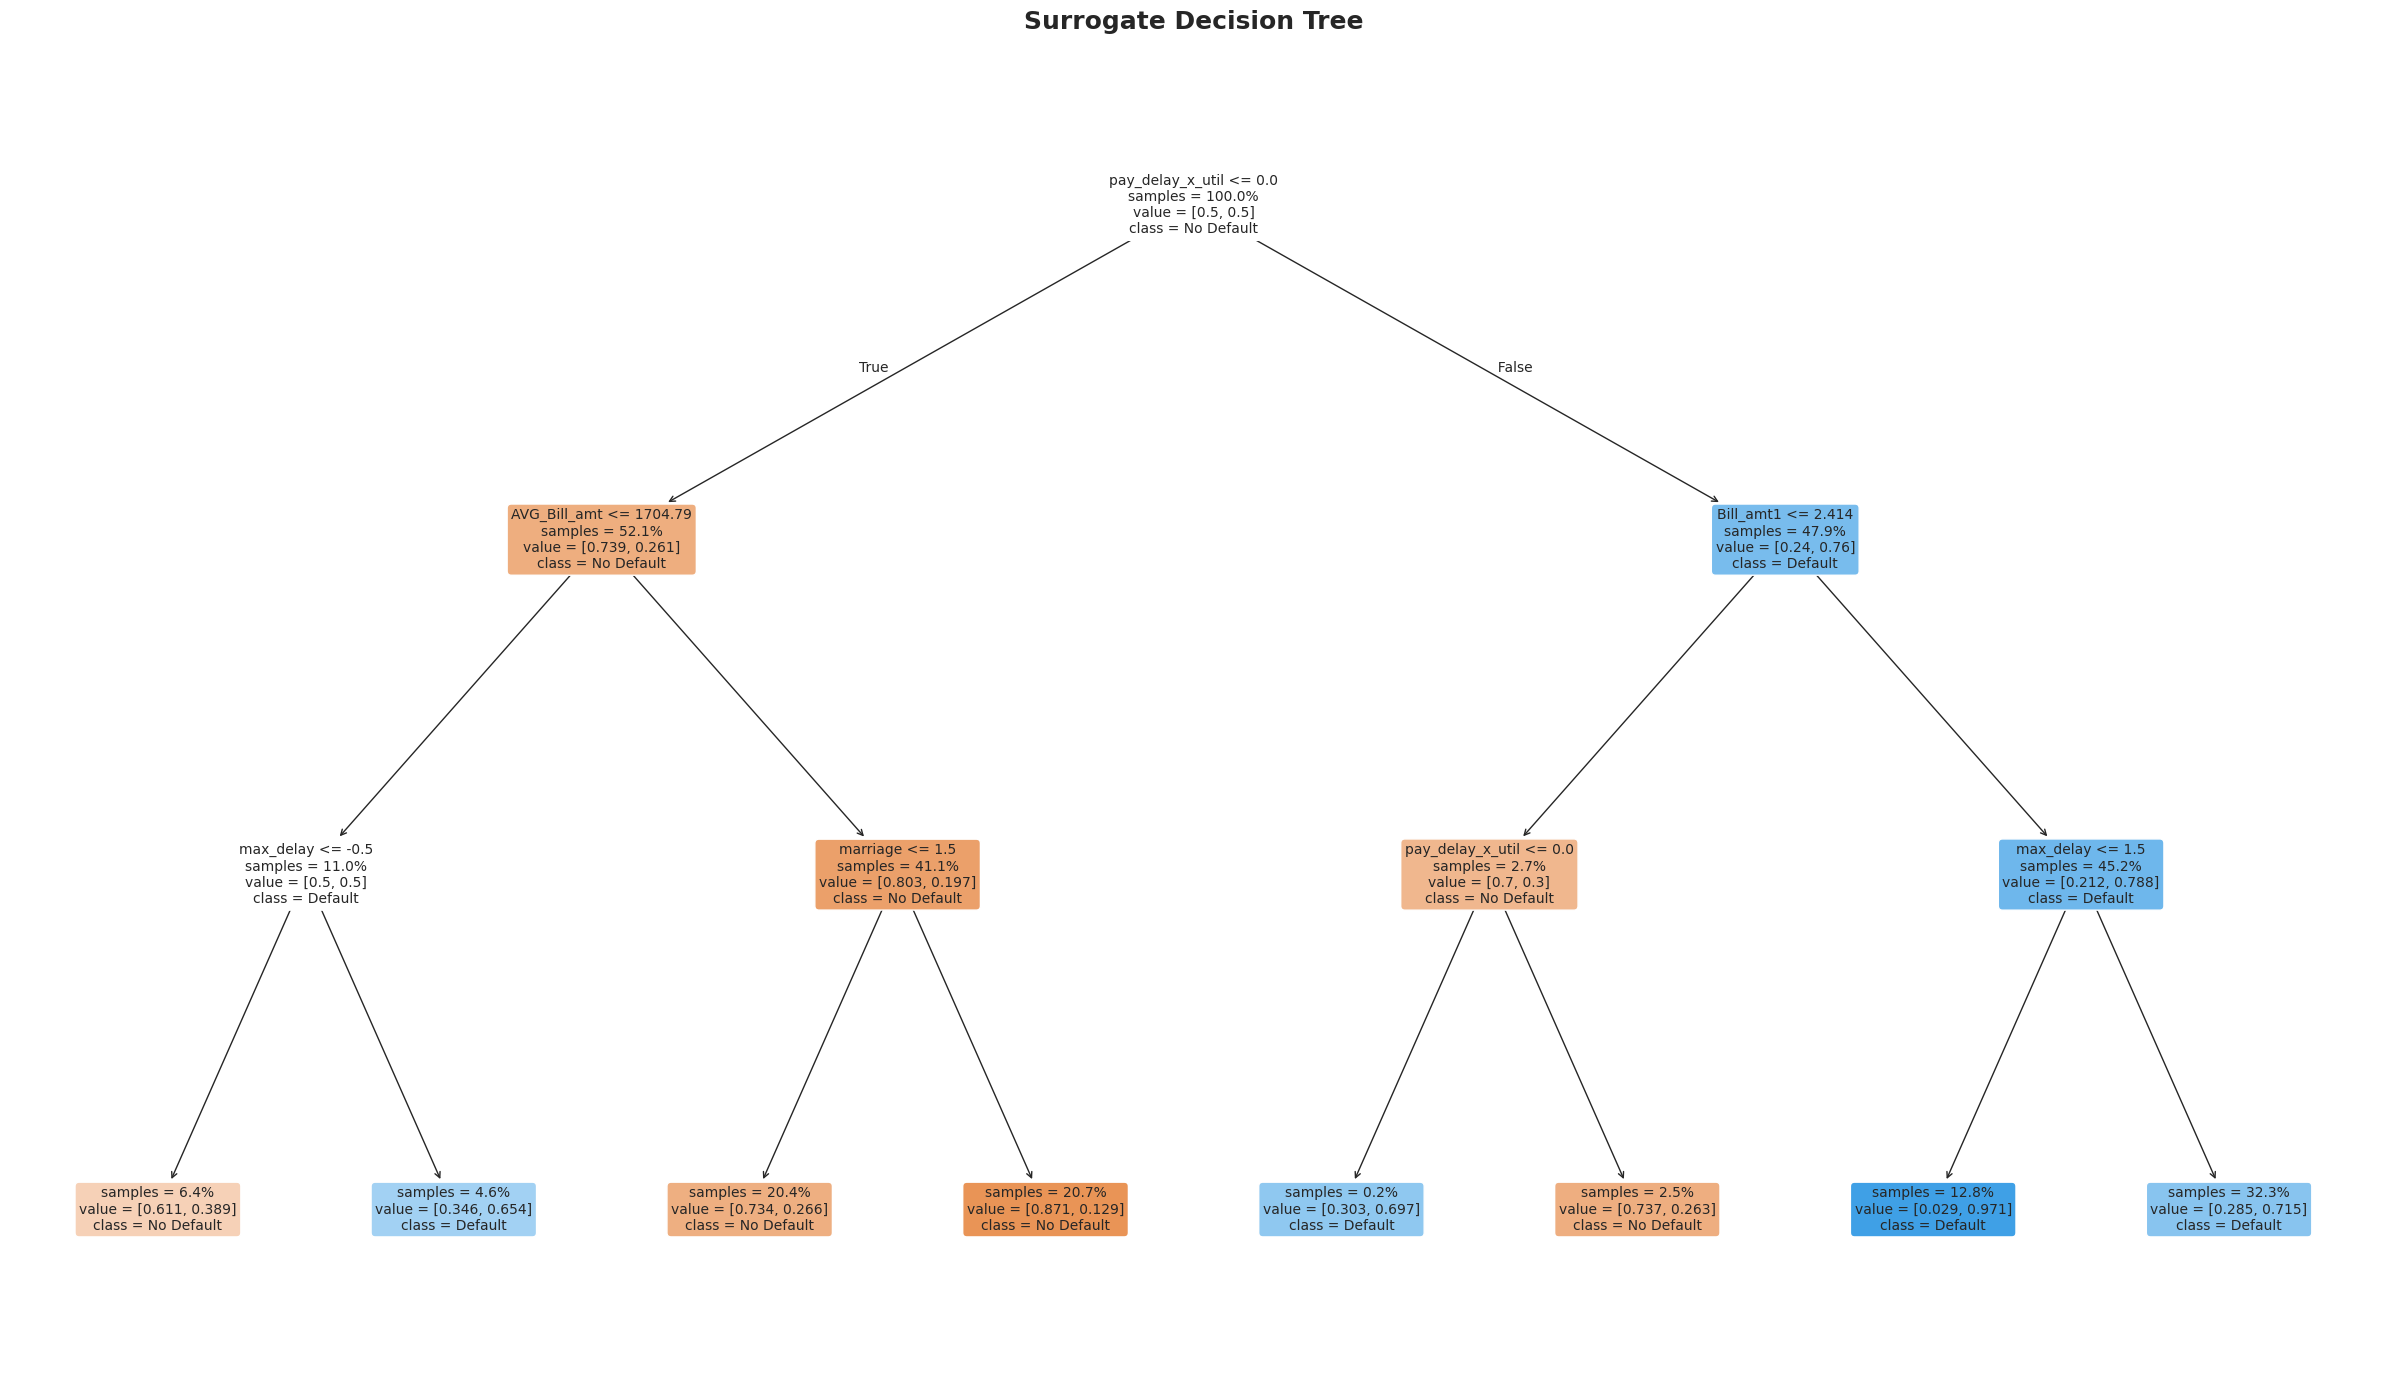

In [51]:
surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate.fit(X_train_smote, y_train_smote)

fig, ax = plt.subplots(figsize=(24, 14))
plot_tree(
    surrogate,
    feature_names=X_train_smote.columns,
    class_names=['No Default', 'Default'],
    filled=True,
    rounded=True,
    fontsize=10,
    impurity=False,
    proportion=True,
    ax=ax
)

plt.title("Surrogate Decision Tree", fontsize=18)
plt.tight_layout()
plt.show()
plt.clf()
plt.close()

## Precision-Recall Curve

- Average Precision (AP): 0.50
- High precision at low recall, but drops as recall increases.
- Model is good at identifying a few confident defaulters, but misses many others.
- Useful for imbalanced datasets like credit default.

## Calibration Curve

- Predicted probabilities are overconfident, especially in the 0.2–0.6 range.
- Calibration improves for high-confidence predictions (closer to 1.0).
- Indicates that probability outputs are not well-calibrated across the board.

## Notes

- Use PR curve when class imbalance is high.
- Apply calibration methods (Platt scaling, isotonic regression) if probabilities are used for decisions.


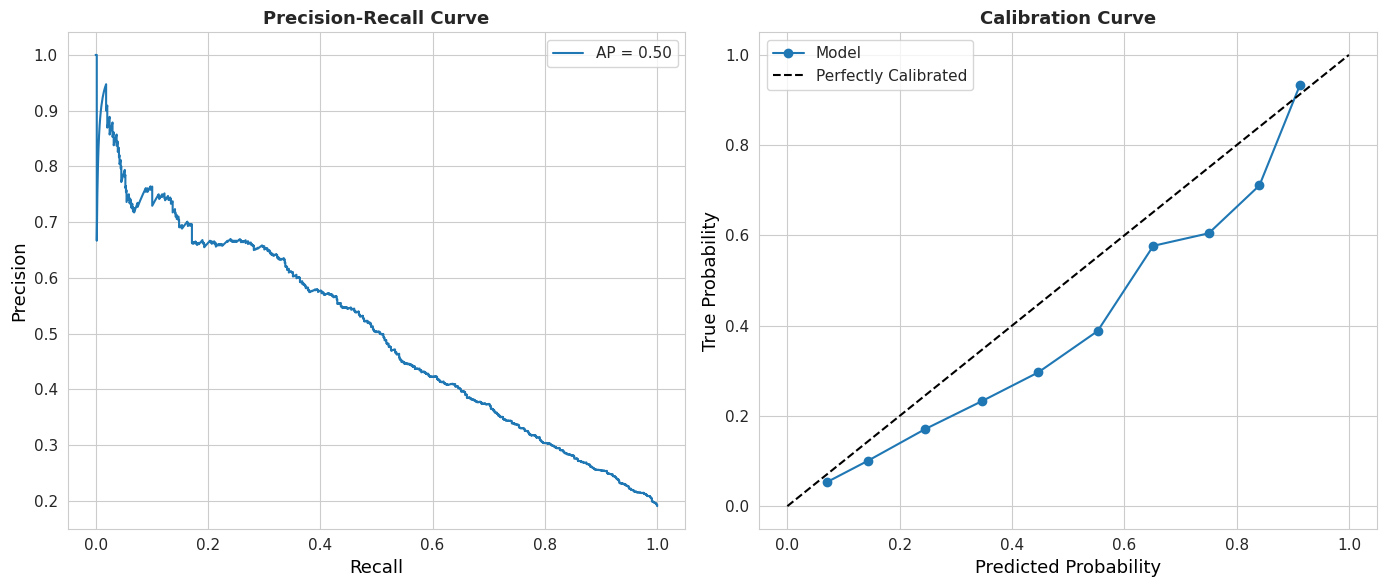

In [52]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(recall, precision, label=f'AP = {avg_precision:.2f}')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(prob_pred, prob_true, marker='o', label='Model')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('True Probability')
axes[1].set_title('Calibration Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
plt.clf()
plt.close()

## ROC Curve

- AUC (Area Under Curve): 0.78
- TPR (True Positive Rate) vs. FPR (False Positive Rate)
- Shows decent model discrimination between defaulters and non-defaulters.
- Better than random (AUC > 0.5), but room for improvement.

## Notes

- ROC is useful when classes are somewhat balanced.
- AUC of 0.78 suggests the model ranks defaulters above non-defaulters 78% of the time.


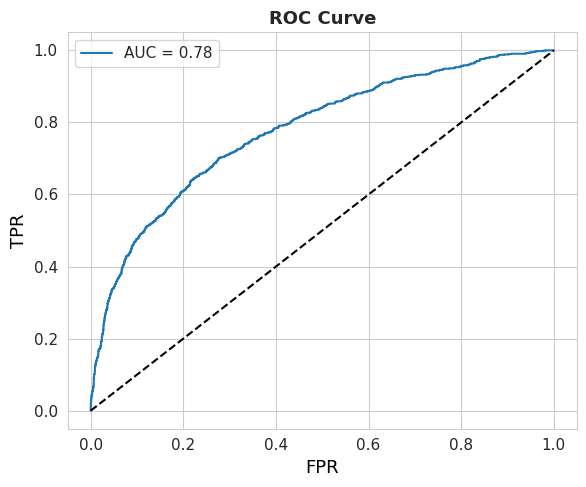

In [53]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC Curve")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()
plt.clf()
plt.close()

## Predicting default probabilities on test data, count class distribution, and export results with customer IDs to CSV.


In [61]:
y_pred_final=final_model.predict(df_test)

In [66]:
pd.Series(y_pred_final).value_counts()

0    4294
1     722
Name: count, dtype: int64

In [69]:
val_original=pd.read_csv(r'/content/validate_dataset_final.csv')

In [74]:
submit=pd.DataFrame({'Customer_ID':val_original['Customer_ID'],'next_month_default':y_pred_final})
submit.to_csv('Credit_Default_Predictions.csv')